# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow, inspired by the [Evol Instruct](https://arxiv.org/abs/2304.12244) paper.



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

In [1]:
!pip install -qU langsmith langchain-core langchain-community langchain-openai langchain-qdrant

In [2]:
!pip install -qU pymupdf ragas

We'll need to provide our LangSmith API key, and set tracing to "true".

In [3]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [6]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Task 2: Loading Source Documents

In order to create a synthetic dataset, we must first load our source documents!

In [7]:
from langchain_community.document_loaders import PyMuPDFLoader

documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

## Task 3: Generate Synthetic Data

Let's first take a peek under the RAGAS hood to see what's happening when we generate a single example.

For simplicities sake - we'll look at a flow that results in a reasoning question.

### Two LLMs To Rule Them All

- `generator_llm` - will generate our seed questions and evolutions
- `critic_llm` - will act as a critic to verify if the evolutions are as we expect them to be

### Entering the Generation

We'll enter the generation process with our `generate_with_langchain_docs()` method - let's look at how that is implemented:

```python
def generate_with_langchain_docs(
    self,
    documents: t.Sequence[LCDocument],
    test_size: int,
    distributions: t.Optional[Distributions] = None,
    with_debugging_logs=False,
    is_async: bool = True,
    raise_exceptions: bool = True,
    run_config: t.Optional[RunConfig] = None,
):
    distributions = distributions or {}
    # chunk documents and add to docstore
    self.docstore.add_documents(
        [Document.from_langchain_document(doc) for doc in documents]
    )

    return self.generate(
        test_size=test_size,
        distributions=distributions,
        with_debugging_logs=with_debugging_logs,
        is_async=is_async,
        raise_exceptions=raise_exceptions,
        run_config=run_config,
    )
```

As you can see - before we do anything, our `doctore` is created using the provided `documents`.

Then, we move on to `generate()`, let's see how that works next!

### Generating Examples!

> NOTE: You can see the full implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/generator.py#L234), we'll work through the pseudo-code.

```python
function generate(test_size, distributions, other_params...):
    # Validate and set default values
    if distributions not provided:
        distributions = DEFAULT_DISTRIBUTION
    
    validate_distributions_sum_to_one(distributions)
    
    set_up_run_config()
    initialize_docstore()
    
    # Initialize evolutions
    for each evolution in distributions:
        initialize_evolution(evolution)
    
    set_up_debugging_logs_if_needed()
    
    # Set up execution environment
    executor = create_executor()
    
    # Get initial nodes
    current_nodes = get_random_nodes_from_docstore(test_size)
    
    total_evolutions = 0
    
    # Distribute evolutions based on probabilities
    for each evolution, probability in distributions:
        num_samples = round(probability * test_size)
        for i in random_sample(range(test_size), num_samples):
            submit_task_to_executor(evolution.evolve, current_nodes[i])
            total_evolutions += 1
    
    # Add filler evolutions if needed
    while total_evolutions < test_size:
        random_evolution = choose_random_evolution(distributions)
        submit_task_to_executor(random_evolution.evolve, current_nodes[total_evolutions])
        total_evolutions += 1
    
    # Get results
    try:
        test_data_rows = executor.get_results()
        if test_data_rows is empty:
            raise Exception("No results generated")

    return test_data_rows
```

In essence, we:

1. Do some validation of inputs, and initialize our evolutions.
2. Get some random nodes from our docstore.
3. Evolve the current nodes based on the desired distribution.
4. Fill with sampled evolutions if we're not at the desired number of rows.

### Peeking into the Complex Evolution Implementation for Reasoning Questions.

> NOTE: You can see the full implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L375). We'll work through the high-level implementation below.

Let's look into how the "Complex Evolution" is implemented:

1. First, we use [`_aevolve()`](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L289) to generate a "Seed Question".

```python
simple_question, current_nodes, _ = await self.se._aevolve(
            current_tries, current_nodes
        )
```

2. We use our provided `question_prompt` to generate a reasoning question.

```python
result = await self.generator_llm.generate(
            prompt=question_prompt.format(
                question=simple_question, context=merged_node.page_content
            )
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L15)):

```python
instruction="""Complicate the given question by rewriting question into a multi-hop reasoning question based on the provided context.
    Answering the question should require the reader to make multiple logical connections or inferences using the information available in given context.
    Rules to follow when rewriting question:
    1. Ensure that the rewritten question can be answered entirely from the information present in the contexts.
    2. Do not frame questions that contains more than 15 words. Use abbreviation wherever possible.
    3. Make sure the question is clear and unambiguous.
    4. phrases like 'based on the provided context','according to the context',etc are not allowed to appear in the question."""
```

3. We verify the question is valid.

```python
is_valid_question, feedback = await self.question_filter.filter(
            reasoning_question
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L390))

```python
instruction="""
Asses the given question for clarity and answerability given enough domain knowledge, consider the following criteria:
1.Independence: Can the question be understood and answered without needing additional context or access to external references not provided within the question itself? Questions should be self-contained, meaning they do not rely on specific documents, tables, or prior knowledge not shared within the question.
2.Clear Intent: Is it clear what type of answer or information the question seeks? The question should convey its purpose without ambiguity, allowing for a direct and relevant response.
Based on these criteria, assign a verdict of "1" if a question is specific, independent, and has a clear intent, making it understandable and answerable based on the details provided. Assign "0" if it fails to meet one or more of these criteria due to vagueness, reliance on external references, or ambiguity in intent.
Provide feedback and a verdict in JSON format, including suggestions for improvement if the question is deemed unclear. Highlight aspects of the question that contribute to its clarity or lack thereof, and offer advice on how it could be reframed or detailed for better understanding and answerability.
"""
```

4. We [handle the question](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/evolutions.py#L401) if it's not valid, otherwise we compress the question:

```python
compressed_question = await self._transform_question(
            prompt=self.compress_question_prompt, question=reasoning_question
        )
```

> PROMPT (implementation [here](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L100))

```python
instruction="""Rewrite the following question to make it more indirect and shorter while retaining the essence of the original question.
    The goal is to create a question that conveys the same meaning but in a less direct manner. The rewritten question should shorter so use abbreviation wherever possible."""
```

5. Filter the newly compressed question based on a comparison to the original simple question.

```python
if await self.evolution_filter.filter(simple_question, compressed_question):
            # retry
            current_nodes = self.se._get_new_random_node()
            logger.debug(
                "evolution_filter failed, retrying with %s", len(current_nodes.nodes)
            )
            return await self.aretry_evolve(current_tries, current_nodes)
```

`filter` is implemented as follows, with our Critic LLM:

```python
    async def filter(self, simple_question: str, compressed_question: str) -> bool:
        prompt = self.evolution_elimination_prompt.format(
            question1=simple_question, question2=compressed_question
        )
        results = await self.llm.generate(prompt=prompt)
        results = results.generations[0][0].text.strip()
        results = await evolution_elimination_parser.aparse(results, prompt, self.llm)
        results = results.dict() if results is not None else {}
        logger.debug("evolution filter: %s", results)
        return results.get("verdict") == 1
```

Let's zoom back out now!



### Generating Answers:

For answer generation, we simply ask the LLM to answer the question we evolved using the context associated with our evolution - that's it!

We will this:

```python
class AnswerFormat(BaseModel):
    answer: str
    verdict: int
```

Using [this prompt](https://github.com/explodinggradients/ragas/blob/fe379a1c97d18ce2c203d80432a3da6622337968/src/ragas/testset/prompts.py#L143):

```python
instruction="""Answer the question using the information from the given context. Output verdict as '1' if answer is present '-1' if answer is not present in the context."""
```

This uses our Generator LLM.

Actually creating our Synthetic Dataset is as simple as running the following cell!

In [8]:
%pip install -qU ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [9]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18") #changed from gpt-3.5-turbo
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

#### ❓ Question #1:

What do the distributions do *specifically*?

> NOTE: More information is available [here](https://docs.ragas.io/en/latest/concepts/testset_generation.html#in-depth-evolution) on the evolution distributions.

The distributions dictionary is used to specify the proportions of different types of questions that the TestsetGenerator will create. 

simple: 0.5: 50% of the generated questions will be of the simple type.<br>
multi_context: 0.4: 40% of the generated questions will be of the multi_context type.<br>
reasoning: 0.1: 10% of the generated questions will be of the reasoning type.

Let's generate!

> NOTE: This cell will take some time, and also make a lot of calls to OpenAI's endpoints! You may run into rate-limits during this cell!

In [10]:
import logging

# Configure logging
logging.basicConfig(filename='debugging_logs_v2.log', level=logging.DEBUG, 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [11]:
testset = generator.generate_with_langchain_docs(documents, 20, distributions, with_debugging_logs=True)

embedding nodes:   0%|          | 0/64 [00:00<?, ?it/s]

Generating:   0%|          | 0/20 [00:00<?, ?it/s]

[ragas.testset.filters.DEBUG] context scoring: {'clarity': 3, 'depth': 3, 'structure': 3, 'relevance': 3, 'score': 3.0}
[ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Forward-looking statements', 'Macroeconomic conditions', 'Fiscal year', 'Product introductions', 'Apple Intelligence']
[ragas.testset.filters.DEBUG] context scoring: {'clarity': 2, 'depth': 3, 'structure': 3, 'relevance': 3, 'score': 2.75}
[ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Unregistered Sales of Equity Securities', 'Share repurchase activity', 'Board of Directors authorization', 'Tim Cook trading plan', 'Rule 10b5-1']
[ragas.testset.filters.DEBUG] context scoring: {'clarity': 3, 'depth': 3, 'structure': 3, 'relevance': 3, 'score': 3.0}
[ragas.testset.evolutions.DEBUG] keyphrases in merged node: ['Selling, General and Administrative expense', 'Provision for Income Taxes', 'Effective tax rate', 'Manufacturing Purchase Obligations', 'Capital Return Program']
[ragas.testset.filters.DE

#### 🏗️ Activity #1:

Using the debugging logs above - trace through a single example of an evolution.

Mark which LLM (Generator, or Critic) was responsible for each step.

To save on costs, both the Generator and Critic LLMs were set to gpt-4o-mini. However, the Generator LLM returned a -1 or 0 

In [13]:
testset.to_pandas()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What information is typically included in a Fo...,[Apple Inc.\nForm 10-Q\nFor the Fiscal Quarter...,The context does not provide specific informat...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
1,What impact can the materialization of risk fa...,"[ ended March 30, 2024 (the “second quarter 20...",The materialization of risk factors can materi...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
2,What is Timothy D. Cook's role in the certific...,"[Exhibit 31.1\nCERTIFICATION\nI, Timothy D. Co...",Timothy D. Cook's role in the certification of...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
3,What is the trading symbol for Common Stock re...,[UNITED STATES\nSECURITIES AND EXCHANGE COMMIS...,The trading symbol for Common Stock registered...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
4,What factors contributed to the changes in the...,"[Selling, General and Administrative\nSelling,...",The factors that contributed to the changes in...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
5,What factors contributed to the increase in se...,[Products and Services Performance\nThe follow...,The increase in services net sales during the ...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
6,What are the new requirements introduced by AS...,"[Segment Reporting\nIn November 2023, the FASB...",ASU 2023-07 introduces new requirements for se...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
7,What was the amount authorized by the Board of...,[Item 2. \nUnregistered Sales of Equity Securi...,The amount authorized by the Board of Director...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
8,What factors contributed to the increase in Am...,[Segment Operating Performance\nThe following ...,The increase in Americas net sales during the ...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True
9,What factors contributed to the increase in re...,[Gross Margin\nProducts and Services gross mar...,The increase in research and development (R&D)...,simple,[{'source': 'https://s2.q4cdn.com/470004039/fi...,True


# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [16]:
from langsmith import Client

client = Client()

dataset_name = "Apple 10-Q Filing Questions - v3"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about Apple's 10-Q Filing"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [17]:
for test in testset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": test[1]["question"]
      },
      outputs={
          "answer": test[1]["ground_truth"]
      },
      metadata={
          "context": test[0]
      },
      dataset_id=dataset.id
  )

## Basic RAG Chain

Time for some RAG!

We'll use the Apple 10-Q filing as our data source today!


In [18]:
rag_documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [19]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [20]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [21]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Apple 10-Q"
)

In [22]:
retriever = vectorstore.as_retriever()

To get the "A" in RAG, we'll provide a prompt.

In [23]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [24]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [25]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [26]:
rag_chain.invoke({"question" : "Does Apple seem to be in good financial health?"})

"I don't know."

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [27]:
eval_llm = ChatOpenAI(model="gpt-4o-mini") #changed from gpt-4o

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [28]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        }
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        }
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`: evaluate the performance of the LLM by comparing the model’s output to expected results
- `labeled_helpfulness_evaluator`: evaluates how helpful the submission is to the user by comparing it to a reference answer
- `dope_or_nope_evaluator`: evaluates whether the submission is 'dope'

## LangSmith Evaluation

In [29]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain"},
)

View the evaluation results for experiment: 'bold-clay-74' at:
https://smith.langchain.com/o/f206ace4-4b0e-5c71-8a93-a9d86db68d52/datasets/94f5cbb6-8cd2-40b3-9f31-3cb92f262c72/compare?selectedSessions=04248c8a-ab39-4473-a73b-3992ac37ddea




0it [00:00, ?it/s]

<ExperimentResults bold-clay-74>

## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [30]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [31]:
rag_documents = PyMuPDFLoader(file_path="https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q3/filing/_10-Q-Q3-2024-As-Filed.pdf").load()

In [32]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

Modifying the chunk size can modify the performance of our application for several reasons:

1. Memory Usage:
 - Larger Chunk Size: Using larger chunks can reduce the overhead of managing multiple smaller chunks, potentially improving memory efficiency. However, it can also lead to higher memory consumption if the chunks are too large.
 - Smaller Chunk Size: Smaller chunks can be easier to manage and may reduce memory usage, but they can increase the overhead of managing many chunks.
2. I/O Operations:
 - Larger Chunk Size: Fewer, larger chunks can reduce the number of I/O operations, which can improve performance, especially for disk or network I/O. However, if the chunks are too large, it can lead to inefficient use of I/O bandwidth.
 - Smaller Chunk Size: More frequent I/O operations with smaller chunks can increase the overhead, potentially slowing down the application.
3. Processing Time:
 - Larger Chunk Size: Processing larger chunks can be more efficient because it reduces the overhead of repeatedly setting up and tearing down processing tasks. However, it can also lead to longer processing times for each chunk, which might not be ideal for real-time applications.
 - Smaller Chunk Size: Smaller chunks can be processed more quickly, which can be beneficial for real-time or interactive applications. However, the increased overhead of managing many small chunks can offset these gains.
4. Parallelism:
 - Larger Chunk Size: Larger chunks can limit the degree of parallelism because fewer chunks are available to distribute across multiple processors or threads.
 - Smaller Chunk Size: Smaller chunks can increase the potential for parallelism, allowing more chunks to be processed simultaneously. However, the overhead of managing many small chunks can reduce the overall efficiency.
5. Network Latency:
 - Larger Chunk Size: When transmitting data over a network, larger chunks can reduce the impact of network latency by sending more data in each transmission. However, if a large chunk is lost or corrupted, it can require retransmitting a significant amount of data.
 - Smaller Chunk Size: Smaller chunks can be more resilient to network issues, as losing a small chunk has less impact. However, the increased number of transmissions can amplify the effects of network latency.

In [33]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

Modifying the embedding model can significantly impact the performance of your application for several reasons:

1. Quality of Embeddings:
 - Accuracy: Different models generate embeddings with varying levels of accuracy. A more accurate model can produce embeddings that better capture the semantic meaning of the input data, leading to improved performance in tasks like search, recommendation, and classification.
 - Dimensionality: The dimensionality of the embeddings can affect both the quality and the computational efficiency. Higher-dimensional embeddings can capture more nuanced information but may require more computational resources.
2. Model Architecture:
 - Complexity: More complex models, such as those based on deep learning, can capture intricate patterns in the data but may require more computational power and memory. Simpler models might be faster but less accurate.
 - Training Data: The quality and quantity of the training data used to develop the embedding model can influence its performance. Models trained on large, diverse datasets tend to generalize better.
3. Computational Efficiency:
 - Inference Speed: Different models have different inference speeds. A faster model can process data more quickly, which is crucial for real-time applications.
 - Resource Utilization: Some models are more resource-intensive than others. Choosing a model that balances performance with resource constraints (e.g., CPU, GPU, memory) is important.
4. Domain Specificity:
 - General vs. Domain-Specific Models: General-purpose embedding models might not perform as well as domain-specific models tailored to your particular use case. For example, a model trained on medical texts will likely perform better in healthcare applications than a general-purpose model.
5. Scalability:
 - Handling Large Datasets: Some models are better suited for scaling to large datasets. Efficient models can handle more data without a significant drop in performance.
 - Parallel Processing: Models that support parallel processing can improve performance by leveraging multiple processors or distributed computing environments.

In [34]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Apple 10-Q (Augmented)"
)

In [35]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [36]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [37]:
dope_rag_chain.invoke({"question" : "Does Apple seem to be in good financial health?"})

"Yo, based on the context, Apple is flexin' some solid numbers! Their net income for the nine months ended June 29, 2024, hit $79 billion, up from $74 billion the previous year. Plus, their gross margin climbed to $136.8 billion, showing they're rakin' it in. So yeah, they seem to be cruisin' along nicely in the financial health lane! 🍏💰"

Finally, we can evaluate the new chain on the same test set!

In [38]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'flowery-substance-66' at:
https://smith.langchain.com/o/f206ace4-4b0e-5c71-8a93-a9d86db68d52/datasets/94f5cbb6-8cd2-40b3-9f31-3cb92f262c72/compare?selectedSessions=207fedca-58e8-4c88-a56b-9573d5e59fef




0it [00:00, ?it/s]

<ExperimentResults flowery-substance-66>

#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

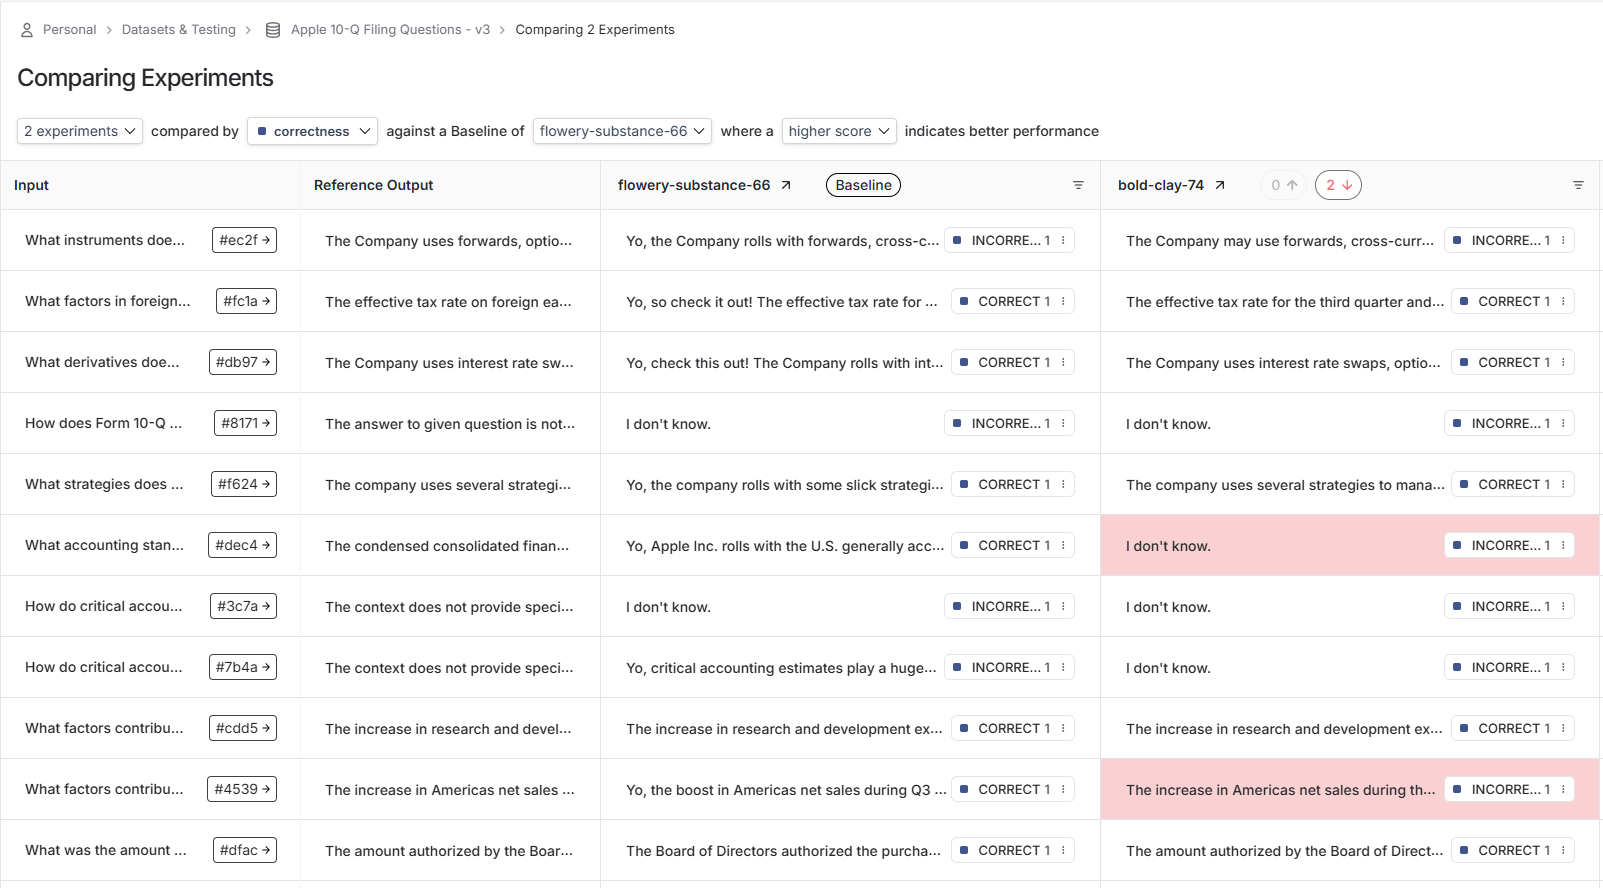

bold-clay-74 used the embedding model "text-embedding-3-small", whereas flowery-substance-66 used "text-embedding-3-large". text-embedding-3-large provides more accurate embeddings and captures more detailed semantic information than text-embedding-3-small, so we should not be surprised that flowery-substance-66 returned more correct outputs than bold-clay-74.